# IBM Applied Data Science -The Battle of Neighbhorhoods


## Opening a New Authentic Indian Restaurant in London City

This final project explores the best locations for Indian restaurants throughout the London City.Londonk City is the biggest city in the United Kingdom with a long history of international immigration. They came from many parts of the world..
With its diverse culture, comes diverse food items. There are many restaurants in London City, each belonging to different categories like Chinese, Indian, French, etc.

#### Firstly we will import all the required libraries for the analysis


In [1]:
import pandas as pd
import numpy as np
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!pip install geocoder
import geocoder # to get coordinates
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')


Libraries imported.


# 1. Data Preparation


Lets build a dataframe of neighborhoods in London by web scraping the data from Wikipedia page. I have used Beautiful Soup package for web scrapping the data

In [2]:
# import the library we use to open URLs
import urllib.request
# import the BeautifulSoup library so we can parse HTML and XML documents
from bs4 import BeautifulSoup

url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
page = urllib.request.urlopen(url)

# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "lxml")
right_table=soup.find('table', class_='wikitable')
#right_table

In [3]:
#Organising the data into 3 cloumns
A=[]
B=[]
C=[]
D=[]

for tag in right_table(['span', 'sup']):
    tag.decompose()

for data in right_table.findAll('tr'):
    ref_data= data.findAll('a')
    for cd in ref_data:
       # print(cd.text)
        A.append(cd.text)
        

   # row_data=row.findall('a')
    #print(row_data)
for tag in right_table(['a']):
    tag.decompose()

for tr in right_table.findAll('tr')[1:]:
    td = tr.find_all('td')
    row = [i.text for i in td]
    B.append(row[1])
    C.append(row[2])
    D.append(row[3])

In [4]:
#Assiging the headers and applying pandas to create dataframe
df=pd.DataFrame(A,columns=['Neighborhood'])
df['London Borough']=B
df['Post town']=C
df['Postcode district']=D
df[df.columns] = df.apply(lambda x: x.str.strip())  #Stripping extra space from the columns
df.head()

,Neighborhood,London Borough,Post town,Postcode district
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
2,Addington,Croydon,CROYDON,CR0
3,Addiscombe,Croydon,CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"


We have to get the geographical coordinates of the neighborhoods. I have used a csv file which contains the London Boroughs and geographical coordinates which was available on the dataset link of London. I have merged the data to get them all together.

In [5]:
df_geodata = pd.read_csv('London_Borughs.csv')
df_geodata.rename(columns={'Borough':'London Borough'},inplace=True)
london_df = pd.merge(df, df_geodata, on='London Borough', how='inner')
london_df.head()

,Neighborhood,London Borough,Post town,Postcode district,Latitude,Longitude
0,Addington,Croydon,CROYDON,CR0,51.3714,0.0977
1,Addiscombe,Croydon,CROYDON,CR0,51.3714,0.0977
2,Coombe,Croydon,CROYDON,CR0,51.3714,0.0977
3,Coulsdon,Croydon,COULSDON,CR5,51.3714,0.0977
4,Croydon,Croydon,CROYDON,CR0,51.3714,0.0977


Let's get the geographical coordinates of London.

In [6]:

address='Croydon, LN'
geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print(address)
    
print('The geograpical coordinate of London City  are {}, {}.'.format(latitude, longitude))

Croydon, LN
The geograpical coordinate of London City  are 51.3713049, -0.101957.


Creating the map, Let's visualize London  neighborhoods in it.

In [7]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neigh in zip(london_df['Latitude'], london_df['Longitude'], london_df['London Borough'], london_df['Neighborhood']):
    label = '{}, {}'.format(neigh, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare credentials and version

In [8]:
CLIENT_ID = 'OAXOSYW1GBKW3UABYT4JOZ0WJNDHW24B2JKLP31O34D0PZAH' # your Foursquare ID
CLIENT_SECRET = 'TN0DARG02KSPHIIDLYXSRE2MZHA2NPFFERLKYC4L5L4EWVHH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OAXOSYW1GBKW3UABYT4JOZ0WJNDHW24B2JKLP31O34D0PZAH
CLIENT_SECRET:TN0DARG02KSPHIIDLYXSRE2MZHA2NPFFERLKYC4L5L4EWVHH


####  Let's explore the first neighborhood in our dataframe.


Get the neighborhood's name.

In [9]:
london_df.loc[0, 'Neighborhood']

'Addington'

Get the neighborhood's latitude and longitude values.

In [10]:
neighborhood_latitude = london_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = london_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = london_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Addington are 51.3714, 0.0977.


#### Now, let's get the top 100 venues that are in Addington within a radius of 1000 meters.


First, let's create the GET request URL. Name your URL url.

In [11]:
LIMIT=100
radius = 1000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=OAXOSYW1GBKW3UABYT4JOZ0WJNDHW24B2JKLP31O34D0PZAH&client_secret=TN0DARG02KSPHIIDLYXSRE2MZHA2NPFFERLKYC4L5L4EWVHH&v=20180605&ll=51.3714,0.0977&radius=1000&limit=100'

Send the GET request and examine the resutls

In [12]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ee0e26b8e93482181dfd927'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Orpington',
  'headerFullLocation': 'Orpington, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 32,
  'suggestedBounds': {'ne': {'lat': 51.38040000900001,
    'lng': 0.11208994399129145},
   'sw': {'lat': 51.36239999099999, 'lng': 0.08331005600870854}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d0638d19d33a143df24c578',
       'name': 'Primo Cafe',
       'location': {'address': 'High Street',
        'crossStreet': 'Knoll Rise',
        'lat': 51.37410479121223,
        'lng': 0.09783041601631369,
        'labeledLatLngs': [{'label': 'di

We know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [14]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Primo Cafe,Coffee Shop,51.374105,0.097830
1,Xi'an,Chinese Restaurant,51.373900,0.098001
2,PureGym,Gym / Fitness Center,51.376850,0.101661
3,Osteria Da Fabrizio,Italian Restaurant,51.375789,0.099196
4,Pato Lounge,Restaurant,51.377009,0.099994


In [ ]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

## 2: Explore Neighborhoods

#### Let's create a function to repeat the same process to all the neighborhoods in Addington

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:

london_venues = getNearbyVenues(names=london_df['Neighborhood'],
                                   latitudes=london_df['Latitude'],
                                   longitudes=london_df['Longitude']
                                  )


Addington
Addiscombe
Coombe
Coulsdon
Croydon
Forestdale
Kenley
New Addington
Norbury
Old Coulsdon
Purley
Riddlesdown
Sanderstead
Selhurst
Selsdon
Shirley
South Croydon
South Norwood
Thornton Heath
Upper Norwood
Waddon
Woodside
Albany Park
Barnehurst
Barnes Cray
Belvedere
Bexley
Bexleyheath
Blackfen
Blendon
Colyers
Crayford
Crook Log
Crossness
East Wickham
Erith
Foots Cray
Lamorbey
Lessness Heath
Longlands
North Cray
North End
Northumberland Heath
Sidcup
Slade Green
Upton
Welling
West Heath
Aldborough Hatch
Barkingside
Gants Hill
Goodmayes
Hainault
Ilford
Loxford
Newbury Park
Redbridge
Seven Kings
South Woodford
Wanstead
Woodford
Aldwych
Bayswater
Belgravia
Charing Cross
Chinatown
Covent Garden
Knightsbridge
Lisson Grove
Little Venice
Maida Vale
Marylebone
Mayfair
Millbank
Paddington
Pimlico
Soho
St James's
St John's Wood
Westminster
Alperton
Brent Park
Brondesbury
Church End
Dollis Hill
Harlesden
Kensal Green
Kingsbury
Neasden
Preston
Queen's Park
Stonebridge
Tokyngton
Wembley
Wembley 

Checking the size of the Datframe

In [19]:
print(london_venues.shape)
london_venues.head()

(5076, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Addington,51.3714,0.0977,Primo Cafe,51.374105,0.097830,Coffee Shop
1,Addington,51.3714,0.0977,Xi'an,51.373900,0.098001,Chinese Restaurant
2,Addington,51.3714,0.0977,Osteria Da Fabrizio,51.375789,0.099196,Italian Restaurant
3,Addington,51.3714,0.0977,Tesco Extra,51.373557,0.096622,Supermarket
4,Addington,51.3714,0.0977,Domino's Pizza,51.374614,0.098277,Pizza Place


In [20]:
london_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Addington,6,6,6,6,6,6
Addiscombe,6,6,6,6,6,6
Albany Park,29,29,29,29,29,29
Aldborough Hatch,41,41,41,41,41,41
Aldwych,1,1,1,1,1,1
Alperton,2,2,2,2,2,2
Anerley,39,39,39,39,39,39
Angel,4,4,4,4,4,4
Aperfield,39,39,39,39,39,39


#### Lets find out how many unique categories in Venue category

In [21]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 90 uniques categories.


In [22]:
# print out the list of categories
london_venues['Venue Category'].unique()

array(['Coffee Shop', 'Chinese Restaurant', 'Italian Restaurant',
       'Supermarket', 'Pizza Place', 'Pub', 'Furniture / Home Store',
       'Clothing Store', 'Department Store', 'Bakery', 'Plaza',
       'Pharmacy', 'Sandwich Place', 'Video Game Store', 'Hotel',
       'American Restaurant', 'Portuguese Restaurant',
       'Fast Food Restaurant', 'Shopping Mall', 'Warehouse Store',
       'Movie Theater', 'Irish Pub', 'Theater', 'Bookstore',
       'Indian Restaurant', 'Buffet', 'Grocery Store',
       'Gym / Fitness Center', 'Stationery Store', 'Turkish Restaurant',
       'Platform', 'Dessert Shop', 'Breakfast Spot', 'Golf Course',
       'Ice Cream Shop', 'Electronics Store', 'Burger Joint', 'Bar',
       'Asian Restaurant', 'Donut Shop', 'Chocolate Shop',
       'Sushi Restaurant', 'Cosmetics Shop', 'Café', 'English Restaurant',
       'Noodle House', 'Fish & Chips Shop', 'Martial Arts Dojo',
       'Metro Station', 'Multiplex', 'Gym', 'Discount Store', 'Boutique',
       'Music

Check whether the results contain Indian Restaurant

In [23]:

# check if the results contain "Indian Restaurant"
"Neighborhood" in london_venues['Venue Category'].unique()

False

## 3.  Analyze Each Neighborhood

In [24]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()


,Neighborhood,Airport,Airport Lounge,Airport Service,American Restaurant,Asian Restaurant,Athletics & Sports,Bakery,Bar,Bookstore,...,Stables,Stationery Store,Supermarket,Sushi Restaurant,Theater,Train Station,Turkish Restaurant,Veterinarian,Video Game Store,Warehouse Store
0,Addington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Addington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Addington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Addington,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Addington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
london_onehot.shape

(5076, 91)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [28]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped.head()

,Neighborhood,Airport,Airport Lounge,Airport Service,American Restaurant,Asian Restaurant,Athletics & Sports,Bakery,Bar,Bookstore,...,Stables,Stationery Store,Supermarket,Sushi Restaurant,Theater,Train Station,Turkish Restaurant,Veterinarian,Video Game Store,Warehouse Store
0,Addington,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,...,0.0,0.00000,0.166667,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.000000
1,Addiscombe,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,...,0.0,0.00000,0.166667,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.000000
2,Albany Park,0.0,0.0,0.0,0.034483,0.0,0.0,0.034483,0.0,0.00000,...,0.0,0.00000,0.068966,0.0,0.00000,0.0,0.00000,0.0,0.034483,0.034483
3,Aldborough Hatch,0.0,0.0,0.0,0.000000,0.0,0.0,0.073171,0.0,0.02439,...,0.0,0.02439,0.073171,0.0,0.02439,0.0,0.04878,0.0,0.000000,0.024390
4,Aldwych,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,...,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.000000


#### Lets see the new size 

In [29]:
london_grouped.shape

(397, 91)

#### Let's print each neighborhood along with the top 5 most common venues

In [30]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Addington----
                venue  freq
0         Pizza Place  0.17
1  Italian Restaurant  0.17
2         Coffee Shop  0.17
3                 Pub  0.17
4         Supermarket  0.17


----Addiscombe----
                venue  freq
0         Pizza Place  0.17
1  Italian Restaurant  0.17
2         Coffee Shop  0.17
3                 Pub  0.17
4         Supermarket  0.17


----Albany Park----
            venue  freq
0             Pub  0.10
1     Coffee Shop  0.10
2  Clothing Store  0.10
3     Supermarket  0.07
4        Pharmacy  0.07


----Aldborough Hatch----
                  venue  freq
0        Clothing Store  0.10
1           Supermarket  0.07
2                Bakery  0.07
3  Fast Food Restaurant  0.07
4    Turkish Restaurant  0.05


----Aldwych----
            venue  freq
0  Breakfast Spot   1.0
1         Airport   0.0
2       Multiplex   0.0
3      Playground   0.0
4        Platform   0.0


----Alperton----
         venue  freq
0          Pub   0.5
1  Golf Course   0.5
2      A

              venue  freq
0              Park  0.33
1  Business Service  0.33
2        Skate Park  0.33
3           Airport  0.00
4       Music Store  0.00


----Bow----
                venue  freq
0            Platform  0.17
1   Food & Drink Shop  0.08
2     Nature Preserve  0.08
3  Italian Restaurant  0.08
4          Lighthouse  0.08


----Bowes Park----
              venue  freq
0              Park  0.33
1  Business Service  0.33
2        Skate Park  0.33
3           Airport  0.00
4       Music Store  0.00


----Brent Park----
         venue  freq
0          Pub   0.5
1  Golf Course   0.5
2      Airport   0.0
3    Multiplex   0.0
4     Platform   0.0


----Brimsdown----
                        venue  freq
0                        Park  0.50
1           Convenience Store  0.25
2  Construction & Landscaping  0.25
3                   Irish Pub  0.00
4          Italian Restaurant  0.00


----Brixton----
            venue  freq
0     Coffee Shop  0.22
1             Pub  0.22
2     Superm

            venue  freq
0  Clothing Store  0.15
1     Coffee Shop  0.13
2             Bar  0.05
3    Burger Joint  0.05
4     Pizza Place  0.05


----Cubitt Town----
                venue  freq
0            Platform  0.17
1   Food & Drink Shop  0.08
2     Nature Preserve  0.08
3  Italian Restaurant  0.08
4          Lighthouse  0.08


----Cudham----
            venue  freq
0  Clothing Store  0.15
1     Coffee Shop  0.13
2             Bar  0.05
3    Burger Joint  0.05
4     Pizza Place  0.05


----Custom House----
                venue  freq
0               Hotel  0.29
1  Chinese Restaurant  0.07
2      Sandwich Place  0.07
3             Rafting  0.07
4            Pharmacy  0.07


----Dagenham----
                  venue  freq
0                  Pool  0.14
1  Gym / Fitness Center  0.14
2                  Park  0.14
3           Supermarket  0.14
4           Golf Course  0.14


----Dalston----
               venue  freq
0  Indian Restaurant  0.38
1              Hotel  0.12
2      Train Sta

              venue  freq
0      Home Service   0.5
1  Business Service   0.5
2           Airport   0.0
3         Multiplex   0.0
4          Platform   0.0


----Grove Park----
                  venue  freq
0     Polish Restaurant  0.17
1  Fast Food Restaurant  0.17
2          Veterinarian  0.17
3                   Pub  0.17
4                  Park  0.17


----Hackney----
               venue  freq
0  Indian Restaurant  0.38
1              Hotel  0.12
2      Train Station  0.12
3               Park  0.12
4         Restaurant  0.12


----Hackney Central----
               venue  freq
0  Indian Restaurant  0.38
1              Hotel  0.12
2      Train Station  0.12
3               Park  0.12
4         Restaurant  0.12


----Hackney Marshes----
               venue  freq
0  Indian Restaurant  0.38
1              Hotel  0.12
2      Train Station  0.12
3               Park  0.12
4         Restaurant  0.12


----Hackney Wick----
               venue  freq
0  Indian Restaurant  0.38
1         

            venue  freq
0  Clothing Store   1.0
1         Airport   0.0
2     Music Store   0.0
3      Playground   0.0
4        Platform   0.0


----Kingston upon Thames----
            venue  freq
0  Clothing Store   1.0
1         Airport   0.0
2     Music Store   0.0
3      Playground   0.0
4        Platform   0.0


----Knightsbridge----
            venue  freq
0  Breakfast Spot   1.0
1         Airport   0.0
2       Multiplex   0.0
3      Playground   0.0
4        Platform   0.0


----Ladywell----
                  venue  freq
0     Polish Restaurant  0.17
1  Fast Food Restaurant  0.17
2          Veterinarian  0.17
3                   Pub  0.17
4                  Park  0.17


----Lambeth----
            venue  freq
0     Coffee Shop  0.22
1             Pub  0.22
2     Supermarket  0.22
3  Soccer Stadium  0.11
4            Café  0.11


----Lamorbey----
            venue  freq
0             Pub  0.10
1     Coffee Shop  0.10
2  Clothing Store  0.10
3     Supermarket  0.07
4        Phar



----North Ockendon----
                  venue  freq
0           Coffee Shop  0.09
1                 Hotel  0.07
2         Shopping Mall  0.07
3        Clothing Store  0.07
4  Fast Food Restaurant  0.05


----North Sheen----
                 venue  freq
0  Sporting Goods Shop   0.2
1  American Restaurant   0.2
2          Coffee Shop   0.2
3        Train Station   0.2
4       Soccer Stadium   0.2


----North Woolwich----
                venue  freq
0               Hotel  0.29
1  Chinese Restaurant  0.07
2      Sandwich Place  0.07
3             Rafting  0.07
4            Pharmacy  0.07


----Northolt----
              venue  freq
0      Home Service   0.5
1  Business Service   0.5
2           Airport   0.0
3         Multiplex   0.0
4          Platform   0.0


----Northumberland Heath----
            venue  freq
0             Pub  0.10
1     Coffee Shop  0.10
2  Clothing Store  0.10
3     Supermarket  0.07
4        Pharmacy  0.07


----Northwood----
           venue  freq
0        Stab

4         Supermarket  0.17


----South Hackney----
               venue  freq
0  Indian Restaurant  0.38
1              Hotel  0.12
2      Train Station  0.12
3               Park  0.12
4         Restaurant  0.12


----South Hornchurch----
                  venue  freq
0           Coffee Shop  0.09
1                 Hotel  0.07
2         Shopping Mall  0.07
3        Clothing Store  0.07
4  Fast Food Restaurant  0.05


----South Norwood----
                venue  freq
0         Pizza Place  0.17
1  Italian Restaurant  0.17
2         Coffee Shop  0.17
3                 Pub  0.17
4         Supermarket  0.17


----South Ruislip----
           venue  freq
0        Stables   1.0
1        Airport   0.0
2  Movie Theater   0.0
3       Platform   0.0
4    Pizza Place   0.0


----South Tottenham----
              venue  freq
0              Park  0.33
1  Business Service  0.33
2        Skate Park  0.33
3           Airport  0.00
4       Music Store  0.00


----South Wimbledon----
         venue  f

                  venue  freq
0        Clothing Store  0.10
1           Supermarket  0.07
2                Bakery  0.07
3  Fast Food Restaurant  0.07
4    Turkish Restaurant  0.05


----Wapping----
                venue  freq
0            Platform  0.17
1   Food & Drink Shop  0.08
2     Nature Preserve  0.08
3  Italian Restaurant  0.08
4          Lighthouse  0.08


----Welling----
            venue  freq
0             Pub  0.10
1     Coffee Shop  0.10
2  Clothing Store  0.10
3     Supermarket  0.07
4        Pharmacy  0.07


----Wembley----
         venue  freq
0          Pub   0.5
1  Golf Course   0.5
2      Airport   0.0
3    Multiplex   0.0
4     Platform   0.0


----Wembley Park----
         venue  freq
0          Pub   0.5
1  Golf Course   0.5
2      Airport   0.0
3    Multiplex   0.0
4     Platform   0.0


----Wennington----
                  venue  freq
0           Coffee Shop  0.09
1                 Hotel  0.07
2         Shopping Mall  0.07
3        Clothing Store  0.07
4  Fast 

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addington,Pizza Place,Coffee Shop,Chinese Restaurant,Supermarket,Italian Restaurant,Pub,Donut Shop,Convenience Store,Cosmetics Shop,Currency Exchange
1,Addiscombe,Pizza Place,Coffee Shop,Chinese Restaurant,Supermarket,Italian Restaurant,Pub,Donut Shop,Convenience Store,Cosmetics Shop,Currency Exchange
2,Albany Park,Pub,Coffee Shop,Clothing Store,Fast Food Restaurant,Italian Restaurant,Supermarket,Pharmacy,Warehouse Store,Furniture / Home Store,Video Game Store
3,Aldborough Hatch,Clothing Store,Fast Food Restaurant,Supermarket,Bakery,Turkish Restaurant,Grocery Store,Coffee Shop,Sandwich Place,Department Store,Warehouse Store
4,Aldwych,Breakfast Spot,English Restaurant,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop


In [33]:
len(london_grouped[london_grouped["Indian Restaurant"] > 0])

31

#### Create a new dataframe with only Indian Restuarant data

In [34]:

london_data = london_grouped[["Neighborhood","Indian Restaurant"]]

In [35]:
london_data.head()

,Neighborhood,Indian Restaurant
0,Addington,0.00000
1,Addiscombe,0.00000
2,Albany Park,0.00000
3,Aldborough Hatch,0.02439
4,Aldwych,0.00000


## 4. Cluster Neighbhorhoods


We will extract Indian restaurant data from above table and fit this into the code for finding best value of K.

C:\Users\nived\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\nived\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\nived\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\nived\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\nived\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clust

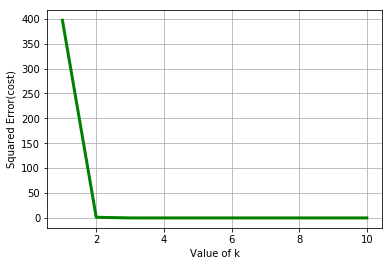

In [36]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

X = london_data.values[:,1:]
X = np.nan_to_num(X)
cluster_london = StandardScaler().fit_transform(X)
cluster_london

cost=[]
for i in range(1,11):
    KM=KMeans(n_clusters=i, max_iter=500)
    KM.fit(cluster_london)
    cost.append(KM.inertia_)
    
plt.plot(range(1,11), cost, color='g',linewidth='3')

plt.xlabel('Value of k')
plt.ylabel('Squared Error(cost)')
plt.grid()
plt.show()

From the above image we see that best value of K will be 2 according to Elbow method.
We will merge above table with our London dataframe so that we will get coordinates of all neighborhoods
Run k-means to cluster the neighborhood into 2 clusters.

In [37]:
# set number of clusters
kclusters = 2

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = london_data

# merge london_grouped with london_data to add latitude/longitude for each
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

london_merged= london_merged.join(london_df.set_index('Neighborhood'), on='Neighborhood')# check the last columns!

In [39]:
london_merged.head()

,Neighborhood,Indian Restaurant,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,London Borough,Post town,Postcode district,Latitude,Longitude
0,Addington,0.00000,0,Pizza Place,Coffee Shop,Chinese Restaurant,Supermarket,Italian Restaurant,Pub,Donut Shop,Convenience Store,Cosmetics Shop,Currency Exchange,Croydon,CROYDON,CR0,51.3714,0.0977
1,Addiscombe,0.00000,0,Pizza Place,Coffee Shop,Chinese Restaurant,Supermarket,Italian Restaurant,Pub,Donut Shop,Convenience Store,Cosmetics Shop,Currency Exchange,Croydon,CROYDON,CR0,51.3714,0.0977
2,Albany Park,0.00000,0,Pub,Coffee Shop,Clothing Store,Fast Food Restaurant,Italian Restaurant,Supermarket,Pharmacy,Warehouse Store,Furniture / Home Store,Video Game Store,Bexley,"BEXLEY, SIDCUP","DA5, DA14",51.4549,0.1505
3,Aldborough Hatch,0.02439,0,Clothing Store,Fast Food Restaurant,Supermarket,Bakery,Turkish Restaurant,Grocery Store,Coffee Shop,Sandwich Place,Department Store,Warehouse Store,Redbridge,ILFORD,IG2,51.5590,0.0741
4,Aldwych,0.00000,1,Breakfast Spot,English Restaurant,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Westminster,LONDON,WC2,51.4973,0.1372


In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Here, we have 2 clusters 0 and 1 respectively. In cluster 0 we have neighborhoods which have more number of Indian Restaurants.
Cluster 0 has Red color in the map.

#### Cluster 0

In [41]:
london_merged.loc[london_merged['Cluster Labels'] == 0]

,Neighborhood,Indian Restaurant,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,London Borough,Post town,Postcode district,Latitude,Longitude
0,Addington,0.00000,0,Pizza Place,Coffee Shop,Chinese Restaurant,Supermarket,Italian Restaurant,Pub,Donut Shop,Convenience Store,Cosmetics Shop,Currency Exchange,Croydon,CROYDON,CR0,51.3714,0.0977
1,Addiscombe,0.00000,0,Pizza Place,Coffee Shop,Chinese Restaurant,Supermarket,Italian Restaurant,Pub,Donut Shop,Convenience Store,Cosmetics Shop,Currency Exchange,Croydon,CROYDON,CR0,51.3714,0.0977
2,Albany Park,0.00000,0,Pub,Coffee Shop,Clothing Store,Fast Food Restaurant,Italian Restaurant,Supermarket,Pharmacy,Warehouse Store,Furniture / Home Store,Video Game Store,Bexley,"BEXLEY, SIDCUP","DA5, DA14",51.4549,0.1505
3,Aldborough Hatch,0.02439,0,Clothing Store,Fast Food Restaurant,Supermarket,Bakery,Turkish Restaurant,Grocery Store,Coffee Shop,Sandwich Place,Department Store,Warehouse Store,Redbridge,ILFORD,IG2,51.5590,0.0741
5,Alperton,0.00000,0,Golf Course,Pub,Warehouse Store,Duty-free Shop,Convenience Store,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Brent,WEMBLEY,HA0,51.5588,0.2817
6,Anerley,0.00000,0,Clothing Store,Coffee Shop,Pizza Place,Bar,Burger Joint,Electronics Store,Ice Cream Shop,Irish Pub,Donut Shop,Portuguese Restaurant,Bromley,LONDON,SE20,51.4039,0.0198
7,Angel,0.00000,0,Martial Arts Dojo,Metro Station,Café,Fish & Chips Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Islington,LONDON,"EC1, N1",51.5416,0.1022
8,Aperfield,0.00000,0,Clothing Store,Coffee Shop,Pizza Place,Bar,Burger Joint,Electronics Store,Ice Cream Shop,Irish Pub,Donut Shop,Portuguese Restaurant,Bromley,WESTERHAM,TN16,51.4039,0.0198
9,Archway,0.00000,0,Martial Arts Dojo,Metro Station,Café,Fish & Chips Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Islington,LONDON,N19,51.5416,0.1022
10,Ardleigh Green,0.00000,0,Coffee Shop,Clothing Store,Hotel,Shopping Mall,Bookstore,Fast Food Restaurant,Pub,Supermarket,Bakery,Café,Havering,HORNCHURCH,RM11,51.5812,0.1837


In the cluster 1: We have all neighborhoods which have highly dense Indian Restaurants. Cluster 1 has purple color on map.

#### Cluster 1

In [42]:
london_merged.loc[london_merged['Cluster Labels'] == 1]

,Neighborhood,Indian Restaurant,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,London Borough,Post town,Postcode district,Latitude,Longitude
4,Aldwych,0.0,1,Breakfast Spot,English Restaurant,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Westminster,LONDON,WC2,51.4973,0.1372
21,Bayswater,0.0,1,Breakfast Spot,English Restaurant,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Westminster,LONDON,W2,51.4973,0.1372
28,Belgravia,0.0,1,Breakfast Spot,English Restaurant,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Westminster,LONDON,SW1,51.4973,0.1372
68,Charing Cross,0.0,1,Breakfast Spot,English Restaurant,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Westminster,LONDON,WC2,51.4973,0.1372
73,Chinatown,0.0,1,Breakfast Spot,English Restaurant,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Westminster,LONDON,W1,51.4973,0.1372
84,Covent Garden,0.0,1,Breakfast Spot,English Restaurant,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Westminster,LONDON,WC2,51.4973,0.1372
198,Knightsbridge,0.0,1,Breakfast Spot,English Restaurant,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Westminster,LONDON,SW1,51.4973,0.1372
209,Lisson Grove,0.0,1,Breakfast Spot,English Restaurant,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Westminster,LONDON,NW8,51.4973,0.1372
211,Little Venice,0.0,1,Breakfast Spot,English Restaurant,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Westminster,LONDON,"W9, W2",51.4973,0.1372
218,Maida Vale,0.0,1,Breakfast Spot,English Restaurant,Cosmetics Shop,Currency Exchange,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Duty-free Shop,Westminster,LONDON,W9,51.4973,0.1372


#### Lets visualize the maximum number of Indian Restaurants 


<function matplotlib.pyplot.show(*args, **kw)>

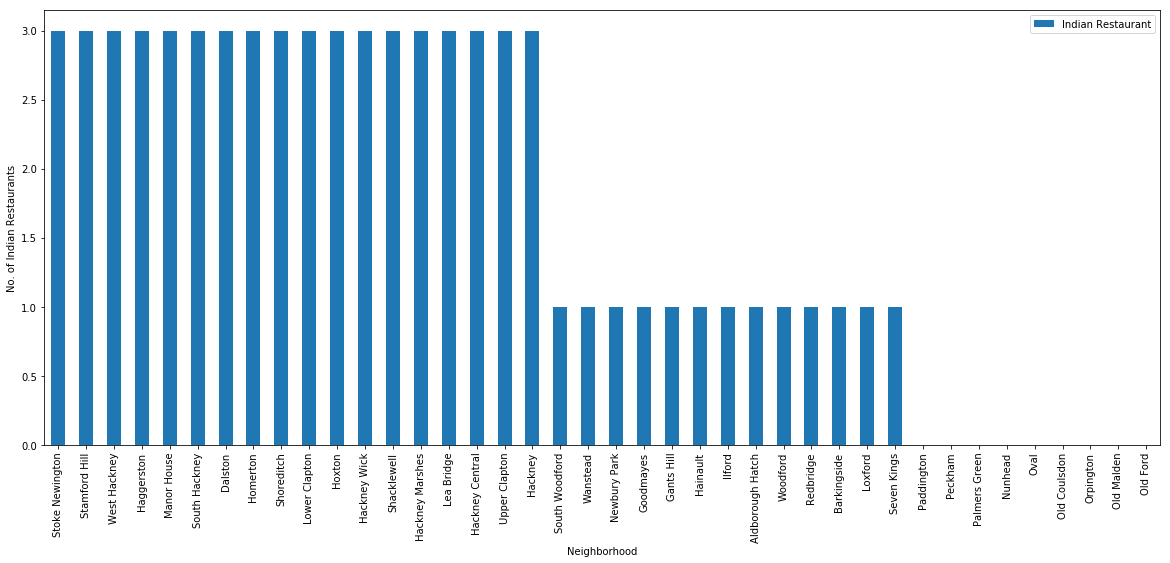

In [43]:
london_graph=pd.DataFrame(london_onehot.groupby('Neighborhood')['Indian Restaurant'].sum())
london_graph=london_graph.sort_values(by='Indian Restaurant', ascending=False)
london_graph.iloc[:40].plot(kind='bar', figsize=(20,8))
plt.xlabel('Neighborhood')
plt.ylabel('No. of Indian Restaurants')
plt.show

## Results

<ol>
<li>Most of the Indian restuarants  are concentrated in the central London city, with the highest number in cluster. On the otherhand, cluster 1 has very low number to totally no of Indian restuarants in the neighborhoods. This represents a great opportunity and high potential areas to open new reaturant as there is less competitions.Therefore, this project recommends property developers to capitalize on these findings to open new restaurants in neighborhoods in cluster 1 with little to no competition. </li>
<li>If we observe the above data Visulaization graph, this gives a fair idea on which neighborhoods to consider and which on not to consider.</li>
<li>Property developers with unique selling propositions to stand out from the competition can also open new Indian restuarants in neighborhoods in cluster 0 with more competition. Lastly, property developers are advised to avoid neighborhoods in cluster 0 which already have high concentration of Indian restuarants and suffering from intense competition.</li>
</ol>
